# PointPillars

Changes made based on [Major bugs](https://github.com/tyagi-iiitv/PointPillars/issues/27)

## Initial Changes (V2)

### Transformation operations

Made changes to `processors.py` to correct the transformation operations

```python
@staticmethod
def transform_labels_into_lidar_coordinates(labels: List[Label3D], R: np.ndarray, t: np.ndarray):
    transformed = []
    for label in labels:
        label.centroid = (label.centroid - t) @ np.linalg.inv(R).T       # corrected 
        label.dimension = label.dimension[[2, 1, 0]] # h w l => l ,w ,h
        label.yaw = -label.yaw   # the label.yaw is in the camera frame, 
        # in the lidar frame, the yaw is negative of label.yaw
        label.yaw -= np.pi / 2
```

In order to get the correct z-center coordinate of the bounding box, the following offset was added in lidar frame

```python
 label.centroid[2] += label.dimension[2] / 2   # the height

```

### Index for bestAnchor allocation


Made changes in `/src/point_pillars.cpp` 

```c++
td::tuple<pybind11::array_t<float>, int, int> createPillarsTarget(const pybind11::array_t<float>& objectPositions,
                                             const pybind11::array_t<float>& objectDimensions,
                                             const pybind11::array_t<float>& objectYaws,
                                             const pybind11::array_t<int>& objectClassIds,
                                             const pybind11::array_t<float>& anchorDimensions,
                                             const pybind11::array_t<float>& anchorZHeights,
                                             const pybind11::array_t<float>& anchorYaws,
                                             float positiveThreshold,
                                             float negativeThreshold,
                                             int nbClasses,
                                             int downscalingFactor,
                                             float xStep,
                                             float yStep,
                                             float xMin,
                                             float xMax,
                                             float yMin,
                                             float yMax,
                                             float zMin,
                                             float zMax,
                                             bool printTime = false)
{
 ...
        float maxIou = 0;
        BoundingBox3D bestAnchor = {};
        int bestAnchorId = 0;
        int bestAnchorXId = 0; # add variable
        int bestAnchorYId = 0; # add variable

        ...


                    if (maxIou < iouOverlap)
                    {
                        maxIou = iouOverlap;
                        bestAnchor = anchorBox;
                        bestAnchorId = anchorCount;
                        bestAnchorXId = xId;
                        bestAnchorYId = yId;
                    }
       ...
     if (maxIou < positiveThreshold) // Comparing maxIOU for that object obtained after 
                                     // checking with every anchor box
        // If none of the anchors passed the threshold, 
        // then we place the best anchor details for that object. 
        {
            negCnt++;

            const auto xId = bestAnchorXId;
            const auto yId = bestAnchorYId;
            ...
      }
       ...

```

#### IMPORTANT: The c++ code must be recompiled after each change. So re-run `python setup.py install`

### Loss function 


In `/src/point_pillars.cpp` when preparing targets in the function `createPillarsTarget`, the angle target was changed.

Old version:
```c++
tensor.mutable_at(objectCount, xId, yId, bestAnchorId, 7) = std::sin(labelBox.yaw - bestAnchor.yaw);
```
New version:
```c++
tensor.mutable_at(objectCount, xId, yId, bestAnchorId, 7) = labelBox.yaw - bestAnchor.yaw;
```

Changed to an updated version of the loss function in `loss_v2.py`, where we have an updated `angle_loss()`  function that uses `add_sin_difference()`

```python
def add_sin_difference(self, y_true, y_pred, factor=1.0):
    if factor != 1.0:
        y_true = factor * y_true
        y_pred = factor * y_pred
    rad_pred_encoding = tf.math.sin(y_pred) * tf.math.cos(y_true)
    rad_tg_encoding = tf.math.cos(y_pred) * tf.math.sin(y_true)
    return rad_tg_encoding, rad_pred_encoding
    
def angle_loss(self, y_true: tf.Tensor, y_pred: tf.Tensor):
    y_true, y_pred = self.add_sin_difference(y_true, y_pred)
    loss = tf.compat.v1.losses.huber_loss(y_true, y_pred, delta=3.0, reduction="none")

    masked_loss = tf.boolean_mask(loss, self.mask)
    return self.angle_weight * tf.reduce_mean(masked_loss)

```

### Bounding box yaw

Changed to an updated version of inference utils in `inference_utils_v2.py`, where
```python
bb_yaw = -np.arcsin(np.clip(ang[value], -1, 1)) + real_anchors[i][4]
```
was changed to
```python
bb_yaw = ang[value] + real_anchors[i][4]
```
 
## Additional changes (V3)

 
Changed the yaw values in `point_pillars_test.py` from degrees to radians (lines 38, 46)

Copied the implementation of a lidar transformation function from [here](https://github.com/tjtanaa/PointPillars/blob/master/processors.py)

```python
@staticmethod
def transform_labels_into_lidar_coordinates(labels: List[Label3D], R: np.ndarray, t: np.ndarray):
    transformed = []
    for label in labels:
        # label.centroid = label.centroid @ np.linalg.inv(R).T - t # OLD
        label.centroid = (label.centroid - t) @ np.linalg.inv(R).T # CORRECTED
        label.dimension = label.dimension[[2, 1, 0]] # h w l => l ,w ,h
        label.yaw -= np.pi / 2
        while label.yaw < -np.pi:
            print("smaller than -pi")
            label.yaw += (np.pi * 2)
        while label.yaw > np.pi:
            print("larger than pi")
            label.yaw -= (np.pi * 2)
        transformed.append(label)
    return labels

```


New version of the network (`network_v2.py`) with some slight modifications. Copied from [here](https://github.com/tjtanaa/PointPillars/blob/master/network_v2.py)
- Changes to the initial pillar layers
- Added parameters to the batch normalization layers in the 2d CNN backbone
- Adjusted the kernel sizes of the transposed convolutions


*For mixed precision training, the `y_true` and `y_pred` input tensors to `focal_loss()` need to be manually cast to `tf.float32`*

In [1]:
# ! python setup.py install

In [2]:
import os
import time
import numpy as np
from glob import glob
from config import Parameters
from network_v2 import build_point_pillar_graph
from loss_v2 import PointPillarNetworkLoss
from processors import SimpleDataGenerator
from readers import KittiDataReader
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from inference_utils_v2 import generate_bboxes_from_pred, GroundTruthGenerator, focal_loss_checker, rotational_nms


import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

physical_devices = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)
K.clear_session()

def enable_amp():
    mixed_precision.set_global_policy("mixed_float16")
    
print("Tensorflow version: ", tf.__version__)
print(physical_devices,"\n")
enable_amp()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/fixes.py:28: UserWarning: Module point_pillars was already imported from /usr/local/lib/python3.6/dist-packages/point_pillars-0.0.1-py3.6-linux-x86_64.egg/point_pillars.cpython-36m-x86_64-linux-gnu.so, but /tf/PythonProjects/object_detection/PointPillars is being added to sys.path
  from pkg_resources import parse_version  # type: ignore


Tensorflow version:  2.4.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] 

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2070 SUPER, compute capability 7.5


In [3]:
DATA_ROOT = "../kitti_dataset/training"  # TODO make main arg
MODEL_ROOT = "./logs"

In [4]:
params = Parameters()

In [5]:
pillar_net = build_point_pillar_graph(params)

In [6]:
# plot_model(pillar_net, show_shapes=True, dpi=100)

In [7]:
# pillar_net.load_weights(os.path.join(MODEL_ROOT, "model_v2.h5"))

In [8]:
loss = PointPillarNetworkLoss(params)

optimizer = Adam(lr=params.learning_rate, decay=params.decay_rate)

pillar_net.compile(optimizer, loss=loss.losses())

data_reader = KittiDataReader()

In [9]:
lidar_files = sorted(glob(os.path.join(DATA_ROOT, "velodyne", "*.bin")))
label_files = sorted(glob(os.path.join(DATA_ROOT, "label_2", "*.txt")))
calibration_files = sorted(glob(os.path.join(DATA_ROOT, "calib", "*.txt")))
validation_len = int(0.3*len(label_files))

In [10]:
training_gen = SimpleDataGenerator(
    data_reader, 
    params.batch_size, 
    lidar_files[:-validation_len], 
    label_files[:-validation_len], 
    calibration_files[:-validation_len]
)

validation_gen = SimpleDataGenerator(
    data_reader, 
    params.batch_size, 
    lidar_files[-validation_len:], 
    label_files[-validation_len:], 
    calibration_files[-validation_len:]
)

In [11]:
log_dir = MODEL_ROOT
ckpt_path = os.path.join(log_dir, "model_v3.h5")

epoch_to_decay = int(
    np.round(params.iters_to_decay/(params.batch_size*int(np.ceil(float(len(label_files)) /params.batch_size)))))

In [12]:
epoch_to_decay

14

In [ ]:
callbacks = [
    ModelCheckpoint(filepath=ckpt_path, monitor='val_loss', save_best_only=True),
    LearningRateScheduler(
        lambda epoch, lr: lr * 0.8 if ((epoch % epoch_to_decay == 0) and (epoch != 0)) else lr, verbose=True),
    EarlyStopping(patience=20, monitor='val_loss'),
]

In [14]:
results = pillar_net.fit(
    training_gen,
    validation_data = validation_gen,
    steps_per_epoch=len(training_gen),
    callbacks=callbacks,
    use_multiprocessing=True,
    epochs=int(params.total_training_epochs),
    workers=8
)

Epoch 1/160

Epoch 00001: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 699s 524ms/step - loss: 1.3415 - occupancy/conv2d_loss: 0.7098 - loc/reshape_loss: 0.0261 - size/reshape_loss: 0.0197 - angle/conv2d_loss: 0.1188 - heading/conv2d_loss: 0.1628 - clf/reshape_loss: 0.3043 - val_loss: 0.3114 - val_occupancy/conv2d_loss: 0.0114 - val_loc/reshape_loss: 0.0194 - val_size/reshape_loss: 0.0184 - val_angle/conv2d_loss: 0.0170 - val_heading/conv2d_loss: 0.1363 - val_clf/reshape_loss: 0.1089
Epoch 2/160

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 698s 531ms/step - loss: 0.3046 - occupancy/conv2d_loss: 0.0078 - loc/reshape_loss: 0.0201 - size/reshape_loss: 0.0167 - angle/conv2d_loss: 0.0166 - heading/conv2d_loss: 0.1366 - clf/reshape_loss: 0.1069 - val_loss: 0.2749 - val_occupancy/conv2d_loss: 0.0035 - val_loc/reshape_loss: 0.0178 - val_s

Epoch 6/160

Epoch 00006: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 712s 541ms/step - loss: 0.1847 - occupancy/conv2d_loss: 0.0021 - loc/reshape_loss: 0.0154 - size/reshape_loss: 0.0117 - angle/conv2d_loss: 0.0114 - heading/conv2d_loss: 0.1101 - clf/reshape_loss: 0.0340 - val_loss: 0.1886 - val_occupancy/conv2d_loss: 0.0020 - val_loc/reshape_loss: 0.0140 - val_size/reshape_loss: 0.0117 - val_angle/conv2d_loss: 0.0104 - val_heading/conv2d_loss: 0.1071 - val_clf/reshape_loss: 0.0434
Epoch 7/160

Epoch 00007: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 704s 536ms/step - loss: 0.1651 - occupancy/conv2d_loss: 0.0020 - loc/reshape_loss: 0.0145 - size/reshape_loss: 0.0114 - angle/conv2d_loss: 0.0107 - heading/conv2d_loss: 0.1011 - clf/reshape_loss: 0.0254 - val_loss: 0.1743 - val_occupancy/conv2d_loss: 0.0019 - val_loc/reshape_loss: 0.0131 - val_s

Epoch 11/160

Epoch 00011: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 704s 536ms/step - loss: 0.1019 - occupancy/conv2d_loss: 0.0017 - loc/reshape_loss: 0.0115 - size/reshape_loss: 0.0094 - angle/conv2d_loss: 0.0082 - heading/conv2d_loss: 0.0627 - clf/reshape_loss: 0.0084 - val_loss: 0.1680 - val_occupancy/conv2d_loss: 0.0017 - val_loc/reshape_loss: 0.0124 - val_size/reshape_loss: 0.0109 - val_angle/conv2d_loss: 0.0089 - val_heading/conv2d_loss: 0.0861 - val_clf/reshape_loss: 0.0480
Epoch 12/160

Epoch 00012: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 709s 538ms/step - loss: 0.0905 - occupancy/conv2d_loss: 0.0017 - loc/reshape_loss: 0.0112 - size/reshape_loss: 0.0091 - angle/conv2d_loss: 0.0076 - heading/conv2d_loss: 0.0548 - clf/reshape_loss: 0.0062 - val_loss: 0.1438 - val_occupancy/conv2d_loss: 0.0016 - val_loc/reshape_loss: 0.0115 - val

Epoch 16/160

Epoch 00016: LearningRateScheduler reducing learning rate to 0.00015999999595806003.
1309/1309 [==============================] - 708s 537ms/step - loss: 0.0472 - occupancy/conv2d_loss: 0.0016 - loc/reshape_loss: 0.0093 - size/reshape_loss: 0.0079 - angle/conv2d_loss: 0.0055 - heading/conv2d_loss: 0.0213 - clf/reshape_loss: 0.0017 - val_loss: 0.1562 - val_occupancy/conv2d_loss: 0.0017 - val_loc/reshape_loss: 0.0104 - val_size/reshape_loss: 0.0095 - val_angle/conv2d_loss: 0.0078 - val_heading/conv2d_loss: 0.0899 - val_clf/reshape_loss: 0.0370
Epoch 17/160

Epoch 00017: LearningRateScheduler reducing learning rate to 0.00015999999595806003.
1309/1309 [==============================] - 710s 538ms/step - loss: 0.0453 - occupancy/conv2d_loss: 0.0016 - loc/reshape_loss: 0.0094 - size/reshape_loss: 0.0077 - angle/conv2d_loss: 0.0056 - heading/conv2d_loss: 0.0192 - clf/reshape_loss: 0.0019 - val_loss: 0.1591 - val_occupancy/conv2d_loss: 0.0016 - val_loc/reshape_loss: 0.0102 - val

Epoch 21/160

Epoch 00021: LearningRateScheduler reducing learning rate to 0.00015999999595806003.
1309/1309 [==============================] - 713s 541ms/step - loss: 0.0369 - occupancy/conv2d_loss: 0.0015 - loc/reshape_loss: 0.0083 - size/reshape_loss: 0.0073 - angle/conv2d_loss: 0.0047 - heading/conv2d_loss: 0.0129 - clf/reshape_loss: 0.0022 - val_loss: 0.1703 - val_occupancy/conv2d_loss: 0.0015 - val_loc/reshape_loss: 0.0095 - val_size/reshape_loss: 0.0094 - val_angle/conv2d_loss: 0.0079 - val_heading/conv2d_loss: 0.1063 - val_clf/reshape_loss: 0.0358
Epoch 22/160

Epoch 00022: LearningRateScheduler reducing learning rate to 0.00015999999595806003.
1309/1309 [==============================] - 711s 540ms/step - loss: 0.0309 - occupancy/conv2d_loss: 0.0014 - loc/reshape_loss: 0.0087 - size/reshape_loss: 0.0069 - angle/conv2d_loss: 0.0043 - heading/conv2d_loss: 0.0088 - clf/reshape_loss: 8.1846e-04 - val_loss: 0.1586 - val_occupancy/conv2d_loss: 0.0015 - val_loc/reshape_loss: 0.0096 -

Epoch 26/160

Epoch 00026: LearningRateScheduler reducing learning rate to 0.00015999999595806003.
1309/1309 [==============================] - 705s 536ms/step - loss: 0.0340 - occupancy/conv2d_loss: 0.0014 - loc/reshape_loss: 0.0075 - size/reshape_loss: 0.0068 - angle/conv2d_loss: 0.0041 - heading/conv2d_loss: 0.0116 - clf/reshape_loss: 0.0025 - val_loss: 0.1733 - val_occupancy/conv2d_loss: 0.0015 - val_loc/reshape_loss: 0.0090 - val_size/reshape_loss: 0.0083 - val_angle/conv2d_loss: 0.0072 - val_heading/conv2d_loss: 0.1171 - val_clf/reshape_loss: 0.0304
Epoch 27/160

Epoch 00027: LearningRateScheduler reducing learning rate to 0.00015999999595806003.
1309/1309 [==============================] - 713s 540ms/step - loss: 0.0238 - occupancy/conv2d_loss: 0.0014 - loc/reshape_loss: 0.0069 - size/reshape_loss: 0.0062 - angle/conv2d_loss: 0.0034 - heading/conv2d_loss: 0.0056 - clf/reshape_loss: 3.5230e-04 - val_loss: 0.1878 - val_occupancy/conv2d_loss: 0.0015 - val_loc/reshape_loss: 0.0097 -

Epoch 31/160

Epoch 00031: LearningRateScheduler reducing learning rate to 0.00012799999967683107.
1263/1309 [===========================>..] - ETA: 18s - loss: 0.0195 - occupancy/conv2d_loss: 0.0013 - loc/reshape_loss: 0.0057 - size/reshape_loss: 0.0057 - angle/conv2d_loss: 0.0030 - heading/conv2d_loss: 0.0035 - clf/reshape_loss: 2.5265e-04

UnknownError: 2 root error(s) found.
  (0) Unknown:  IndexError: index 1795162116 is out of bounds for axis 4 with size 10
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/data_utils.py", line 567, in get_index
    return _SHARED_SEQUENCES[uid][i]
  File "/tf/PythonProjects/object_detection/PointPillars/processors.py", line 173, in __getitem__
    label_transformed)
  File "/tf/PythonProjects/object_detection/PointPillars/processors.py", line 115, in make_ground_truth
    sel = select_best_anchors(target)
  File "/tf/PythonProjects/object_detection/PointPillars/processors.py", line 18, in select_best_anchors
    return arr[ind]
IndexError: index 1795162116 is out of bounds for axis 4 with size 10
"""


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/script_ops.py", line 249, in __call__
    ret = func(*args)

  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/autograph/impl/api.py", line 620, in wrapper
    return func(*args, **kwargs)

  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py", line 891, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/data_adapter.py", line 807, in wrapped_generator
    for data in generator_fn():

  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/data_utils.py", line 788, in get
    six.reraise(*sys.exc_info())

  File "/usr/local/lib/python3.6/dist-packages/six.py", line 703, in reraise
    raise value

  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/data_utils.py", line 779, in get
    inputs = self.queue.get(block=True, timeout=5).get()

  File "/usr/lib/python3.6/multiprocessing/pool.py", line 644, in get
    raise self._value

IndexError: index 1795162116 is out of bounds for axis 4 with size 10


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
  (1) Unknown:  IndexError: index 1795162116 is out of bounds for axis 4 with size 10
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/data_utils.py", line 567, in get_index
    return _SHARED_SEQUENCES[uid][i]
  File "/tf/PythonProjects/object_detection/PointPillars/processors.py", line 173, in __getitem__
    label_transformed)
  File "/tf/PythonProjects/object_detection/PointPillars/processors.py", line 115, in make_ground_truth
    sel = select_best_anchors(target)
  File "/tf/PythonProjects/object_detection/PointPillars/processors.py", line 18, in select_best_anchors
    return arr[ind]
IndexError: index 1795162116 is out of bounds for axis 4 with size 10
"""


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/script_ops.py", line 249, in __call__
    ret = func(*args)

  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/autograph/impl/api.py", line 620, in wrapper
    return func(*args, **kwargs)

  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py", line 891, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/data_adapter.py", line 807, in wrapped_generator
    for data in generator_fn():

  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/data_utils.py", line 788, in get
    six.reraise(*sys.exc_info())

  File "/usr/local/lib/python3.6/dist-packages/six.py", line 703, in reraise
    raise value

  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/data_utils.py", line 779, in get
    inputs = self.queue.get(block=True, timeout=5).get()

  File "/usr/lib/python3.6/multiprocessing/pool.py", line 644, in get
    raise self._value

IndexError: index 1795162116 is out of bounds for axis 4 with size 10


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[gradient_tape/focal_loss/logistic_loss/mul/Shape_1/_10]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_10051]

Function call stack:
train_function -> train_function


Validation curves go down, and then bounce back up. Is this a flaw in the model / preprocessing? Or is it just severe overfitting?

In [15]:
results = pillar_net.history

In [16]:
def plot_history(results):
    
    plt.figure(figsize=(16,8))
    
    plt.subplot(2,4,1)  
    plt.plot(results.history['loss'], 'r', label='Training')
    plt.plot(results.history['val_loss'], 'b', label='Validation')
    plt.title('Focal loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(prop={'size': 12})

    plt.subplot(2,4,2)
    plt.plot(results.history['occupancy/conv2d_loss'], 'r', label='Training')
    plt.plot(results.history['val_occupancy/conv2d_loss'], 'b', label='Validation')
    plt.title('Occupancy loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(prop={'size': 12})

    plt.subplot(2,4,3)
    plt.plot(results.history['loc/reshape_loss'], 'r', label='Training')
    plt.plot(results.history['val_loc/reshape_loss'], 'b', label='Validation')
    plt.title('Loc loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(prop={'size': 12})
    
    plt.subplot(2,4,4)
    plt.plot(results.history['size/reshape_loss'], 'r', label='Training')
    plt.plot(results.history['val_size/reshape_loss'], 'b', label='Validation')
    plt.title('Size loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(prop={'size': 12})
    
    plt.subplot(2,4,5)
    plt.plot(results.history['angle/conv2d_loss'], 'r', label='Training')
    plt.plot(results.history['val_angle/conv2d_loss'], 'b', label='Validation')
    plt.title('Angle loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(prop={'size': 12})
    
    plt.subplot(2,4,6)
    plt.plot(results.history['heading/conv2d_loss'], 'r', label='Training')
    plt.plot(results.history['val_heading/conv2d_loss'], 'b', label='Validation')
    plt.title('Heading loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(prop={'size': 12})
    
    plt.subplot(2,4,7)
    plt.plot(results.history['clf/reshape_loss'], 'r', label='Training')
    plt.plot(results.history['val_clf/reshape_loss'], 'b', label='Validation')
    plt.title('Clf loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(prop={'size': 12})
    
    plt.subplot(2,4,8)
    plt.plot(results.history['lr'], 'g')
    plt.title('Learning Rate', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.0e'))
    
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.25, wspace=0.2)
    
    plt.show()

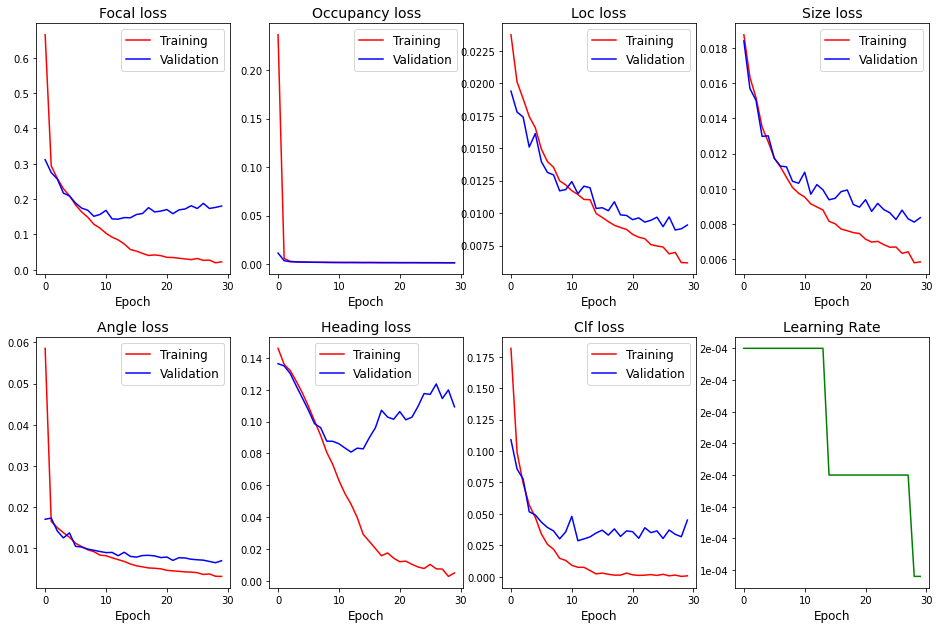

In [17]:
plot_history(results)

In [18]:
n_predictions = 200
eval_gen = SimpleDataGenerator(
    data_reader=data_reader, 
    batch_size=params.batch_size, 
    lidar_files=lidar_files[:n_predictions], 
    label_files=label_files[:n_predictions], 
    calibration_files=calibration_files[:n_predictions]
)

In [19]:
occupancy, position, size, angle, heading, classification = pillar_net.predict(
    eval_gen,
    batch_size=params.batch_size,
    verbose=1
)

50/50 [==============================] - 20s 395ms/step


In [25]:
set_boxes, confidences = [], []
loop_range = occupancy.shape[0] if len(occupancy.shape) == 4 else 1
for i in range(loop_range):
    bbox = generate_bboxes_from_pred(
        occupancy[i], 
        position[i], 
        size[i], 
        angle[i], 
        heading[i],
        classification[i], 
        params.anchor_dims, 
        occ_threshold=0.2
    )
    set_boxes.append(bbox)
    conf = [float(boxes.conf) for boxes in set_boxes[-1]]
    confidences.append(conf)
print('Scene 1: Box predictions with occupancy > occ_thr: ', len(set_boxes[0]))

Scene 1: Box predictions with occupancy > occ_thr:  3


In [26]:
set_boxes[0:10]

[[((2.011642167366914, 11.864198095668177),
   (3.7309319097184357, 1.5975482225052744),
   76.99444464546555),
  ((1.887241066271097, 11.686808915939572),
   (3.847341589832098, 1.592627072224424),
   80.60912760330345),
  ((11.01122380665553, 4.908659154124821),
   (3.746497305454284, 1.5921841858652854),
   82.92321063514258)],
 [((53.40517837263839, -2.7156480012362834),
   (3.891612309012345, 1.6544929750933193),
   -3.881330127940616)],
 [((24.611870120758688, -4.916636565530332),
   (4.015035715531951, 1.8139202388215097),
   2.154079447229234),
  ((67.82660641997798, -4.857662116561197),
   (3.295409533498457, 1.4939071877882952),
   4.720153343872698),
  ((67.88121171396804, -4.7911495335370695),
   (3.311703685441472, 1.5434480897105942),
   5.794279991806304),
  ((67.84042736820642, -4.732669984861742),
   (3.3877091222899764, 1.5208961713447593),
   5.2920706962872535),
  ((68.0949117917359, -4.936254115847712),
   (3.374363469144953, 1.5446474305487783),
   3.7290433764323

In [27]:
confidences[0:10]

[[0.2278742790222168, 0.21335789561271667, 0.22271493077278137],
 [0.21269363164901733],
 [0.20026375353336334,
  0.22702808678150177,
  0.2107328325510025,
  0.20913629233837128,
  0.2630961537361145,
  0.274711012840271,
  0.20453207194805145],
 [0.20941197872161865,
  0.22297550737857819,
  0.24075880646705627,
  0.23814992606639862,
  0.24793556332588196,
  0.2240685671567917,
  0.3626960217952728,
  0.42464005947113037,
  0.4068738520145416,
  0.2780390679836273,
  0.48906129598617554,
  0.5403618812561035,
  0.6952797174453735,
  0.5412692427635193,
  0.4393443763256073,
  0.3477241098880768,
  0.42006510496139526,
  0.3776354491710663,
  0.584560751914978,
  0.4354449212551117,
  0.3382423520088196,
  0.30086296796798706,
  0.3277836740016937,
  0.2236911505460739,
  0.21084412932395935,
  0.30032292008399963],
 [0.27976545691490173,
  0.20310759544372559,
  0.2503185272216797,
  0.24788913130760193,
  0.23628391325473785,
  0.2833130359649658,
  0.3220142722129822,
  0.20656158

In [28]:
# NMS
nms_boxes = rotational_nms(set_boxes, confidences, occ_threshold=0.3, nms_iou_thr=0.5)
print('Scene 1: Boxes after NMS with iou_thr: ', len(nms_boxes[0]))

# Do all the further operations on predicted_boxes array, which contains the predicted bounding boxes
gt_gen = GroundTruthGenerator(data_reader, label_files, calibration_files, network_format=False)
gt_gen0 = GroundTruthGenerator(data_reader, label_files, calibration_files, network_format=True)

AttributeError: 'tuple' object has no attribute 'reshape'

In [ ]:
for seq_boxes, gt_label, gt0 in zip(nms_boxes, gt_gen, gt_gen0):
    print("\n---------- New Scenario ---------- ")
    focal_loss_checker(gt0[0], occupancy[0], n_occs=-1)
    print("---------- ------------ ---------- ")
    for gt in gt_label:
        print(gt)
    for pred in seq_boxes:
        print(pred)